In [ ]:
#pip install neo4j
#pip install networkx

In [1]:
from neo4j import GraphDatabase
import pandas as pd
from tabulate import tabulate
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [2]:
user="neo4j"
password="neo4j123"

In [3]:
driver = GraphDatabase.driver("bolt://localhost", auth=(user, password))

In [4]:
def print_result_summary(summary):
    if summary.counters.nodes_created > 0 :
        print(f"Created {summary.counters.nodes_created:,d} nodes")
    if summary.counters.nodes_deleted > 0 :
        print(f"Deleted {summary.counters.nodes_deleted:,d} nodes")
    if summary.counters.relationships_created > 0 :
        print(f"Created {summary.counters.relationships_created:,d} relationships")
    if summary.counters.relationships_deleted > 0 :
        print(f"Deleted {summary.counters.relationships_deleted:,d} relationships")
    if summary.counters.properties_set > 0 :
        print(f"Set {summary.counters.properties_set:,d} properties")
    if summary.counters.labels_added > 0 :
        print(f"Added {summary.counters.labels_added:,d} labels")
    if summary.counters.labels_removed > 0 :
        print(f"Removed {summary.counters.labels_removed:,d} labels")
    if summary.counters.indexes_added > 0 :
        print(f"Added {summary.counters.indexes_added:,d} indexes")
    if summary.counters.indexes_removed > 0 :
        print(f"Removed {summary.counters.indexes_removed:,d} indexes")
    if summary.counters.constraints_added > 0 :
        print(f"Added {summary.counters.constraints_added:,d} constraints")
    if summary.counters.constraints_removed > 0 :
        print(f"Removed {summary.counters.constraints_removed:,d} constraints")
    if summary.counters.system_updates > 0 :
        print(f"Contains {summary.counters.system_updates:,d} system updates")


In [5]:
result = {"label": [], "count": []}
with driver.session() as session:
    labels = [row["label"] for row in session.run("CALL db.labels()")]
    for label in labels:
        query = f"MATCH (:`{label}`) RETURN count(*) as count"
        count = session.run(query).single()["count"]
        result["label"].append(label)
        result["count"].append(count)
df = pd.DataFrame(data=result)
print(tabulate(df.sort_values("count"), headers='keys',tablefmt='psql', showindex=False))

+---------+---------+
| label   |   count |
|---------+---------|
| Spam    |    1667 |
| Status  |   57695 |
| User    | 1511659 |
+---------+---------+


# Sample spam statuses

In [6]:
spamQ="""
MATCH (s:Spam)
WHERE s.is_retweet=0
RETURN s.text AS status, s.is_retweet AS is_retweet, s.hashtag_count AS hashtag_count
"""
with driver.session() as session:
    result = session.run(spamQ)
    spamDf = pd.DataFrame([dict(record) for record in result])

In [7]:
pd.set_option('display.max_colwidth', None)

In [8]:
print(spamDf['status'].head(5).to_string(index=False))

                                                                                             🙏สวัสดีค่ะ มีใครว่างหาค่าขนมอยู่ไหมค่ะ รีวิวแน่นมากค่า\nเค้ามีงานมาแนะนำทำง่ายค่ะแค่15-30นาที\n\n#chaelisa #OMGรักจังวะผิดจังหวะ #MAMA2022 #ซนซน  #OnitsukaTiger #jaeten #งานออนไลน์ได้เงินจริง https://t.co/y9iDkDA3jM
                                                                                                                            📢สวัสดีค่ะ มีใครว่างหาค่าขนมอยู่ไหมคะ  \nแค่15-30นาทีเค้ามีงานมาแนะนำทำง่ายๆค่ะ\n#แอนจักรพงษ์ #MissUniverse 'Birthday' MV Teaser #หมอก้อง #คุณชายEP8 #TillyBirds https://t.co/O8kQO32pm3
                                                              🙏สวัสดีค่ะ มีใครว่างหาค่าขนมอยู่ไหมค่ะ รีวิวแน่นมากค่า\nเค้ามีงานมาแนะนำทำง่ายค่ะแค่15-30นาที\n\n#จอสไบร์ท #แอนจักรพงษ์ #ตี๋ลี่เร่อปา #chaelisa #jaeten #WhyYouYMeEP2 win x taokaenoi #ตามรอยกลรักEp3 #งานออนไลน์ไม่จํากัดอายุ https://t.co/1h2QUEQpeQ
              แจก!!! 10velyLightStick จำนวน 1 แท่ง รีทวิต และทำการทวิตเอง

# Sample users

In [9]:
query="""
MATCH (u:User)
WHERE EXISTS( u.is_spammer )
RETURN u.id AS id, u.description AS description,
u.is_spammer AS is_spammer, u.friends_count AS friends_count,
u.followers_count AS followers_count, u.favorites_count AS favorites_count,
u.statuses_count AS statuses_count;
"""
with driver.session() as session:
    result = session.run(query)
    userDf = pd.DataFrame([dict(record) for record in result])

In [10]:
userDf[['id', 'description']].head(5).style.hide(axis="index")

id,description
2860686722,แล้วมันจะผ่านไปด้วยดี
3012397195,ได้ดีกว่าหรือแม้แต่ใกล้เคียงก็ยังไม่มี ไม่มีออปชั่นสอง ไม่มีออปชั่นสาม มันมีแต่เขาคนเดียว
3140473124,I’m always tired but never of Nong PP kubb.❤️❤️
947456372,|| BKPP : Both of us? Both of us she/her //🐧 https://t.co/IRAo8lDFpT
935425423911010304,เปลี่ยนมาเป็นติ่ง แอ๊คหลักแล้วเพื่อนบ่น 😅 อยากซัพพอร์ทให้เค้าได้ทำตามความฝัน #บกพพ ❤️💙


In [11]:
userDf.loc[userDf['is_spammer']==1][['id', 'description']].head(5).style.hide(axis="index")

id,description
2175612528,Waiting for #SO10 #TEN #TENLEE #텐 #เตนล์ #이영흠 #李永钦 #テン #⃝TEN #TENChittaphon #tenlee_1001 #威神V_TEN_李永钦 #NCT텐 #WayV텐 #SuperM텐 🎧 PMN https://t.co/DMl1AGta5P
1574640867826335744,None
1491730082934956032,สำรอง👉สนใจงานออนไลน์ | หารายได้เสริม | ติดต่อสอบถามได้ค่ะ | รับงานรีวิว|งานโปรโมท | ติดต่อ(งาน) DM แอดไลน์ @281ffnej หรือ ลิ้งค์ด้านล่าง
1570664347021758464,📲 ทักมาสอบถามรายละเอียดก่อนได้นะคะกดลิงค์ 👉 https://t.co/JoBU63Vo0T หรือแอดไลน์ 👉 @824aeukp (มีแอดด้วยนะคะ)💕
1569619106600726528,💨 มีรายได้เสริม ทักมาได้ตลอด เลยนะคะ 💨 🌴 ᴏᴘᴇɴ 10.00 ᴀᴍ - 22.00 ᴘᴍ 🌴 🪺 สอบถามเพิ่มเติม https://t.co/yQtuvH8Th6 หรือ @888tyfff 🪺


In [12]:
userDf.groupby(['is_spammer'])['is_spammer'].count()

is_spammer
0    24897
1      799
Name: is_spammer, dtype: int64

# Construct NX graoh

In [13]:
import networkx as nx
%matplotlib inline

In [14]:
#https://stackoverflow.com/questions/59289134/constructing-networkx-graph-from-neo4j-query-result
def graph_from_cypher(results):
    G = nx.MultiDiGraph()

    nodes = list(results.graph()._nodes.values())
    for node in nodes:
        G.add_node(node.id, labels=node._labels, properties=node._properties)

    rels = list(results.graph()._relationships.values())
    for rel in rels:
        G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)
        
    return G

In [15]:
query="""
MATCH (u1:User)
WHERE u1.is_spammer=1
OPTIONAL MATCH (u1)-[r]-(u2:User)
WHERE u2.is_spammer=1
RETURN *
"""
G = graph_from_cypher(driver.session().run(query))

# Visualize spammer network

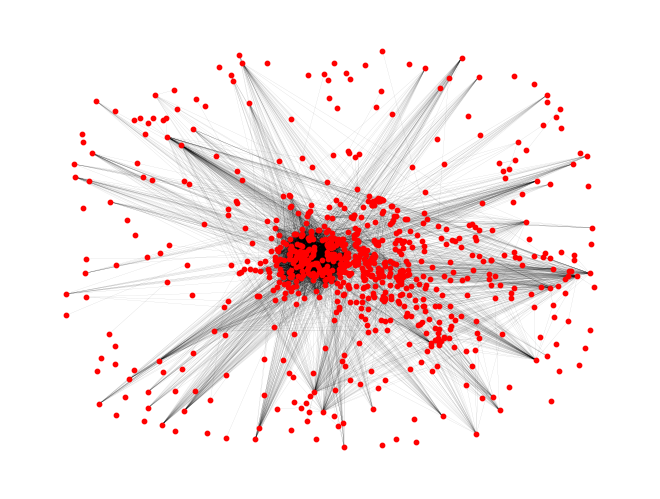

In [16]:
pos = nx.spring_layout(G, iterations=10, seed=1)
#pos= nx.nx_agraph.graphviz_layout(G)
options = {
    'node_color': 'red',
#    'edge_color': 'darkblue',
    'node_size': 10,
#    'arrowsize': 5,
    'arrows': False,
    'width': 0.03
}
nx.draw(G, pos, **options)

# Graph projections

In [17]:
### Graph projection: DIRECTED ###
projection1 = """
CALL gds.graph.project('follows', 'User', 'FOLLOWS');
"""
### Graph projection: UNIDIRECTED ###
projection2 = """
CALL gds.graph.project('unifollows','User',
  {
    FOLLOWS: {orientation: 'UNDIRECTED'}
  });
"""
with driver.session() as session:
    result1 = session.run(projection1)
    proj1Df = pd.DataFrame([dict(record) for record in result1])
    result2 = session.run(projection2)
    proj2Df = pd.DataFrame([dict(record) for record in result2])

# Triangles

In [6]:
query = """
MATCH (nonSpammer:User)-[:FOLLOWS]->(u1:User)-[:FOLLOWS]->(nonSpammer),
(nonSpammer:User)-[:FOLLOWS]->(u2:User)-[:FOLLOWS]->(nonSpammer),
(u1)-[:FOLLOWS]->(u2)-[:FOLLOWS]->(u1)
WHERE u1.is_spammer=1 AND u2.is_spammer=1 AND coalesce(nonSpammer.is_spammer,0)=0
OPTIONAL MATCH (nonSpammer)-[:TWEETS]->(s:Status)
RETURN nonSpammer.id AS id, nonSpammer.description AS description, collect(s.text)[0] as status;
"""

with driver.session() as session:
    result = session.run(query)
    nonSpammerDf = pd.DataFrame([dict(record) for record in result])

In [7]:
nonSpammerDf

,id,description,status
0,1567014870893350913,https://t.co/Gl7luWRUx0,RT @Pani_BrightStar: ภูมิใจในทีมแบล็คมาก เก่งม...
1,3169049431,ᴍʏ ꜰᴀᴠ ᴘᴇʀꜱᴏɴ ; ꒰ @wixxiws x @Earth_pirapat ꒱ ♡,RT @lunarinsummer: มาทำให้ฉันชอบ ช่วยรับผิดชอบ...
2,1364121229477613573,🌏🪐Always​ Be​ Side​ You ﹅♥︎₊˚.Your Smile is My...,ꔣ ˖ น่ารักแบบนี้มีอีกไหม\nอยากเก็บเอาไว้ไม่แบ่...
3,1395866785660899329,Always beside you➡ PIRAPAT W. ✨ แฟนต๋าคนโปรด :...,#LOVERESPONSEPRESS\nชอบกล้องมุมนี้มากกกกกกกกกก...
4,1431821551574274050,None,RT @iamxploy: หัวใจดวงเดียวกัน 💗 \n\n#เอิร์ทมิ...
5,1584799481823784960,🌟 มั่นคง ร่ำรวย 🌟แอดไลน์👉🏻 @huay2525,RT @huay25255: 🌟 มั่นคง จ่ายสูง จ่ายจริง\nคลิก...
6,1541305885339054080,ขออนุญาตแนะนำตัวค่ะ😁 ชื่อกระถิน อายุ30+++ เป็น...,RT @AAiirinNNN: เอ็นดูเด็กเร้กทเวิค \nพี่เอิร์...
7,1377672096487067649,โพแฟน @Earth_Pirapat ส่วน@Wixxiws คือลูกต๋า (ร...,RT @KhingKhing_eng: ก็อยากน่ารักให้เธอหันมา~~ ...
8,1388115424294940672,#เอิร์ทมิกซ์,มาทำให้ฉันชอบ ไข่เจียวกรอบๆ\nข้าวสองถ้วย\nเข้า...
9,1393157249065897987,ทาสความรัก เอิร์ทมิกซ์ และเจ้าพวกแงวของเค้า,RT @f4188m: #LOVERESPONSEPRESS\n\nอ้าย said : ...


# Community Detections - Louvain

In [21]:
### Run Louvain algorithm ###
query = """
CALL gds.louvain.write('follows', { writeProperty: 'louvainId' })
YIELD communityCount, modularity, modularities
"""
with driver.session() as session:
    result = session.run(query)
    df = pd.DataFrame([dict(record) for record in result])
    print_result_summary(result.consume())

In [11]:
query = """
MATCH (u:User)
WITH u.louvainId AS communityId, count(u) AS size, COLLECT(id(u)) AS ids,
sum(u.is_spammer) as spammer_count
MATCH (u1:User)-[r]-(u2:User)
WHERE id(u1) IN ids AND id(u2) IN ids
RETURN communityId, size, COUNT(distinct r)*1.0/(size*(size-1)) AS relationship_density,
spammer_count, spammer_count*100/size as spammer_ratio
ORDER BY size DESC LIMIT 40
"""
with driver.session() as session:
    result = session.run(query)
    louvainDf = pd.DataFrame([dict(record) for record in result])

In [12]:
louvainDf.style.format({
    "size": "{:,.0f}",
}).highlight_max(['relationship_density','spammer_count', 'spammer_ratio'], color='red')

,communityId,size,relationship_density,spammer_count,spammer_ratio
0,135279,"2,692",0.006529,455,16
1,142521,"2,403",0.019374,7,0
2,163620,"2,247",0.014556,1,0
3,138600,"2,058",0.010966,8,0
4,149297,"1,664",0.030979,2,0
5,155276,"1,559",0.021321,5,0
6,14057,"1,543",0.022085,6,0
7,162057,"1,454",0.020034,7,0
8,15366,"1,323",0.033413,1,0
9,200271,913,0.031739,0,0


# Communities with more than 50% are spammers

In [22]:
louvainDf[louvainDf['spammer_ratio']>=50].sort_values(by='spammer_ratio', ascending=False)

,communityId,size,spammer_count,spammer_ratio
33,352562,191,177,92


In [23]:
spammer_community=louvainDf[louvainDf['spammer_ratio']>=50].sort_values(by='spammer_ratio', ascending=False)['communityId'].values[0]
spammer_community=int(spammer_community)
spammer_community

352562

# Find non-spammers in the community

In [24]:
### Users in the community ###
query = """
MATCH (u:User)
WHERE u.louvainId=$spammer_community
OPTIONAL MATCH (u)-[:TWEETS]->(s:Status)
RETURN distinct u.id AS id,
coalesce(u.is_spammer, 0) AS is_spammer,
u.description AS description, collect(s.text)[0] AS Tweet;
"""
params={"spammer_community": spammer_community}
with driver.session() as session:
    result = session.run(query, params)
    userDf2 = pd.DataFrame([dict(record) for record in result])

In [25]:
userDf2.loc[userDf2['is_spammer']==0][['id', 'description', 'Tweet']].style.hide(axis="index")

id,description,Tweet
1567014870893350912,https://t.co/Gl7luWRUx0,RT @Pani_BrightStar: ภูมิใจในทีมแบล็คมาก เก่งมาก วันนี้มันส์สุดๆ พี่จอสโครตเก่ง กองเชียร์กองใจ แน่นเว่อร์ สุดยอดเลยทุกคน🖤🥰 #10fight10ss3XJo…
1134645062019604480,I remember 🐧,None
1582695499031023616,สำรอง👉สนใจงานออนไลน์ | หารายได้เสริม | ติดต่อสอบถามได้ค่ะ | รับงานรีวิว|งานโปรโมท | ติดต่อ(งาน) DM หรือ ลิ้งค์ด้านล่าง,None
1578253305448652800,สนใจติดต่อยื่นสินเชื่อ คลิก https://t.co/9oEyLSExqv,None
1574761452980023296,ใครที่อยากหาค่าขนมเชิญทางนี้เลยจ้าา 👉 https://t.co/sVLHaFY5vv หรือ @541cvbwt มี(@) ด้วยค่ะ,None
1568930552241332224,สนใจงานรายได้เสริมแอด @111dprux มีแอดด้วยนะคะ หรือคลิก https://t.co/DQVJj2zkrS,None
1573948858203136000,สนใจงานรายได้เสริมแอด @111dprux มีแอดด้วยนะคะ หรือคลิก https://t.co/4jcuoV9zfh,None
1570259161073717248,สนใจงานรายได้เสริมแอด @818mfzhf มีแอดด้วยนะคะ หรือคลิก https://t.co/DBKyEJ1v1n,None
1577887783863013376,สนใจงานรายได้เสริมแอด @743lhfkd มีแอดด้วยนะคะ หรือคลิกhttps://t.co/oQpSpn6Wyh,None
1578308283546279936,ตัวเองสามารถแอดไลน์เข้าไปสอบถามเพิ่มเติมได้น๊าาาาาาาาาา สนใจแอดไลน์👉 https://t.co/RhNO9A5UE5,None


# Communities with top users

In [26]:
query = """
MATCH (u:User)
WITH u.louvainId AS communityId, count(u) AS size, sum(u.is_spammer) as spammer_count, COLLECT(id(u)) AS ids
CALL {
WITH ids
CALL gds.pageRank.stream('follows', {sourceNodes:ids })
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS topUser, score AS score
WHERE topUser.followers_count >= 100000
WITH topUser, score
ORDER BY score DESC LIMIT 3
RETURN COLLECT(topUser.screen_name) AS topUsers
}
RETURN communityId, size, spammer_count, topUsers AS topUsers
ORDER BY size DESC LIMIT 40;
"""
with driver.session() as session:
    result = session.run(query)
    louvainDf = pd.DataFrame([dict(record) for record in result])

In [27]:
louvainDf

,communityId,size,spammer_count,topUsers
0,135279,2692,455,"[netflixth, JacksonWang852, THarmharm]"
1,142521,2403,7,"[NCTsmtown, WayV_official, Ten_TH]"
2,163620,2247,1,"[CwrNew, zee_pruk, DomundiTV]"
3,138600,2058,8,"[GMMTV, bbrightvc, winmetawin]"
4,149297,1664,2,"[gulfkanawut, MSuppasit, Gulfkanawutofc]"
5,155276,1559,5,"[BamBam1A, GOT7, marktuan]"
6,14057,1543,6,"[LILITEAMTH327, BLACKPINK, BamBam1A]"
7,162057,1454,7,"[BTS_twt, _candyclover, bts_bighit]"
8,15366,1323,1,"[warwanarat, yinyin_anw, aunzajung]"
9,200271,913,0,"[bb0un, Prem_space, wabisabiTH]"


In [28]:
driver.close()